# AAFragpy description

`aafragpy` is a Python package that provide the set of functions that allow to calculate:
- differential cross-sections of secondary particle production in nuclear interaction for given combination of primary and target nuclei for a given value of energy (function `get_cs_value`);
- matrix of differential cross-sections of secondary particle production in nuclear interaction for a given combination of primary and target nuclei for a given range of energies (function `get_cs_matrix`);
- differential spectrum of secondary particles produced in the interaction of a given primary spectrum with target nuclei (function `get_spectrum`).

`aafragpy` uses high-energy cross-section parameterisations obtained using the results of QGSJET-II-04m calculations (M Kachelrieß et al., Comp. Phys. Comm. 2019).
For the calculation of the secondaries produced by low-energy primaries the opportunity to use codes from Kamae et al. 2006 and Kafexhiu et al. 2014 (GEANT-based, for gamma-rays only) is presented.

`aafragpy` requires:
- Python3
- `numpy`

This notebook also uses following packages for the figures:
- `matplolib`
- `seaborn`

## A demonstration how the `aafragpy` works

Here we show an exmaple of procedure usage which allows to calculate differential cross-sections and differential spectra of secondary particles in nuclear interactions in astrophysical sources.

Units of routines are: GeV for energy, mb for cross-sections.

In [1]:
# Some useful imports
import matplotlib.pyplot as plt
import numpy as np

Let's start importing the routine for differential cross-section calculation:

In [2]:
#import AAFragpy routine for differential cross-section
from aafragpy import get_cs_value

Function `get_cs_value` allows to get the differential cross-section of a given combination of primary, target, and secondary particles.

Allowed primary/target combinations:
    `p-p`,
    `p-He`,
    `He-p`,
    `He-He`,
    `C-p`,
    `Al-p`,
    `Fe-p`

Allowed secondary particles:

| Particle | code |
|----------|------|
| $\gamma$ | `gam`|
|   $e^-$  | `el` |
|   $e^+$  | `pos`|
|${\nu_e}$ |`nu_e`|
| $\bar{\nu_e}$ | `anu_e` |
| ${\nu_{\mu}}$ | `nu_mu` |
| $\bar{\nu_{\mu}}$ | `anu_mu` |
|   $p^+$  | `p` |
|   $p^-$  | `ap`|
|   $n$  | `n` |
|   $\bar{n}$  | `an`|

## Differential cross-section calculation for single primary energy

Here is an example of calculation of gamma and electron neutrino differential cross-sections for p-p interaction for p total energy 200 GeV using default secondary energy grid:

In [3]:
gamma_energy, gamma_cs = get_cs_value('gam','p-p',200)
el_energy, el_cs = get_cs_value('nu_e','p-p',200)

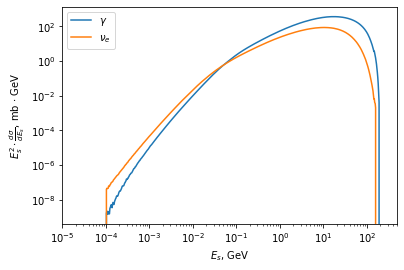

In [4]:
plt.loglog(gamma_energy, gamma_cs*gamma_energy**2,label='$\gamma$')
plt.loglog(el_energy, el_cs*el_energy**2,label=r'$\nu_e$')
plt.legend()
plt.xlim(1e-5,5e2)
plt.ylabel(r'$E_s^2 \cdot \frac{d \sigma}{d E_s}$, mb $\cdot$ GeV')
plt.xlabel(r'$E_s$, GeV')
plt.show()

You can specify your own energy grid for secondaries if you want:

In [5]:
el_energy, el_cs = get_single_cs_value('nu_e','p-p',200,np.logspace(-3,2,500))

If your primary energy is not covered by AAFrag corresponding message will be returned:

In [6]:
get__cs_value('nu_e','p-p',3,np.logspace(-3,2,500))

Primary kinetic energy 3 GeV is not in range: 4 GeV -- 396 EeV avaliable for primary/target combination: p-p


## Differential cross-section calculation for multiple primary energies
Now let's consider the routine that allows to reconstruct the matrix of differential cross-sections for multiple primary particle energies

In [7]:
#import aafragpy routine for differential cross-section matrix
from aafragpy import get_cs_matrix

By default this function reconstructs the tabulated values:

In [8]:
energy_primary, energy_secondary, cs_matrix = get_cs_matrix ('anu_mu','C-p')

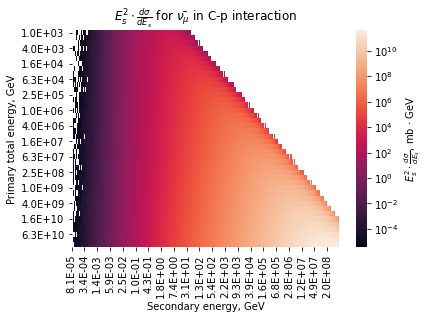

In [9]:
from matplotlib.colors import LogNorm
import seaborn as sns
import pandas as pd
sci_format = np.vectorize(lambda f: format(f, '2.1E'))
cross_section_matrix = pd.DataFrame(cs_matrix*energy_secondary**2,
                                    index = sci_format(energy_primary),
                                    columns = sci_format(energy_secondary)
                                   )

s = sns.heatmap(cross_section_matrix, norm=LogNorm(),
            cbar_kws={'label': r'$E_s^2 \cdot \frac{d \sigma}{d E_s}$, mb $\cdot$ GeV'})
plt.ylabel('Primary total energy, GeV')
plt.xlim(0,1300)
plt.xlabel('Secondary energy, GeV')
plt.title(r'$E_s^2 \cdot \frac{d \sigma}{d E_s}$ for $\bar{\nu_{\mu}}$ in C-p interaction')
plt.show()

User-defined grids for primary and secondary energies can be used as well:

In [10]:
energy_primary, energy_secondary, cs_matrix = get_cs_matrix ('anu_mu','C-p',E_primaries=[2e3,2e4,2e5],
                                                             T_secondaries = np.logspace(-2,10,100))

## Differential secondary spectrum calculation using `aafragpy`

Finally, we can get the spectrum of secondaries considering several types of the primary spectrum using function `get_spectrum`.
For this small number of predefined artificial spectra (power-law in momentum) can be used:

In [11]:
from aafragpy import get_spectrum
from aafragpy import power_law, power_law_exp_decay

Of course, users can construct their own functions to model the primary spectra or use the experimental data.

First, we should calculate the matrix of differential cross-sections for secondaries:

In [12]:
energy_primary, energy_secondary, cs_matrix = get_cs_matrix ('gam','p-p')

Second, we should calculate the spectrum of primaries, here is the example for power-law exp-decay function:

In [13]:
prim_spectrum = power_law_exp_decay(energy_primary,J0=1,gamma=2,p_cut=1e6)

And now we can calculate the spectrum of secondaries using the following equation:

$\frac{dN}{dE} = \int  \frac{d\sigma}{dE} \cdot J(E) \cdot dE $:

In [14]:
energy_sec, spec = get_spectrum (energy_primary,energy_secondary,cs_matrix,prim_spectrum)

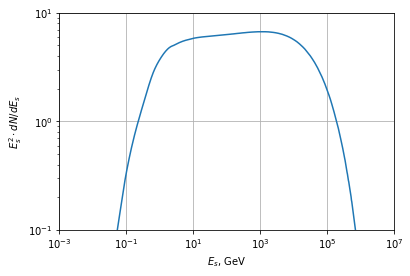

In [15]:
power=2
plt.loglog(energy_sec,spec*energy_sec**power)
plt.xlabel('$E_s$, GeV')
plt.ylabel('$E_s^{'+str(power)+'} \cdot dN/dE_s$')
plt.ylim(1e-1,1e1)
plt.xlim(1e-3,1e7)
plt.grid()
plt.show()

## Differential secondary spectrum calculation using aafragpy and low-energy codes

User have an option to use the AAFragpy code together with Kamae2006 [2] or Kafexhiu2014 [3] codes.
These codes give opportunity to calculate cross-sections of secondary production for low-energy primaries.
Both codes are applicable only for $pp$ interactions, Kamae2006 is suitable for calculation of lepton and gamma-ray production, while Kafexhiu2014 allows to calculate only gamma-ray production.

Kamae2006 and Kafexhiu2014 parametrizations were carefully transferred to Python code resulting in `Kamae2006.py` and `Kafexhiu2014.py` modules.

Below an example of how Kamae2006 (or Kafexhiu2014) calculations can be added to AAFrag calculations is given.

In [16]:
from aafragpy import get_cs_matrix_Kamae2006, get_cs_matrix_Kafexhiu2014
energy_primary =  np.logspace(-1,11,250)

# the energy boundary between low-energy code and AAFrag
rolloffenergy = 10

energy_primary_AAFrag = energy_primary[energy_primary>=rolloffenergy]
energy_primary_low = energy_primary[energy_primary<rolloffenergy]

energy_primary_AAFrag, energy_secondary, cs_matrix_AAFrag = get_cs_matrix ('gam', 'p-p', E_primaries=energy_primary_AAFrag)
energy_primary_Kamae2006, energy_secondary, cs_matrix_Kamae2006 = get_cs_matrix_Kamae2006 ('gam', E_primaries=energy_primary_low, T_secondaries=energy_secondary)
energy_primary_Kamae2006, energy_secondary, cs_matrix_Kafexhiu2014 = get_cs_matrix_Kafexhiu2014 (E_primaries=energy_primary_low, T_secondaries=energy_secondary)

prim_spectrum = power_law_exp_decay(energy_primary,J0=1,gamma=2.2,p_cut=1e6)

energy_sec, spec_AAFrag = get_spectrum (energy_primary_AAFrag,energy_secondary,cs_matrix_AAFrag,prim_spectrum[energy_primary>=rolloffenergy])
energy_sec, spec_Kamae2006 = get_spectrum (energy_primary_low,energy_secondary,cs_matrix_Kamae2006,prim_spectrum[energy_primary<rolloffenergy])
energy_sec, spec_Kafexhiu2014 = get_spectrum (energy_primary_low,energy_secondary,cs_matrix_Kafexhiu2014,prim_spectrum[energy_primary<rolloffenergy])

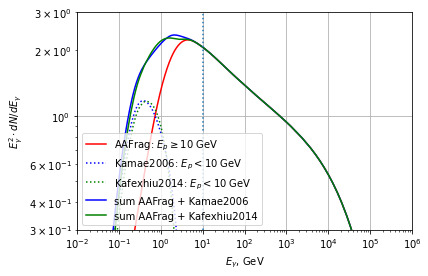

In [17]:
power = 2

plt.loglog(energy_sec, spec_AAFrag*energy_sec**power,'r-', label="AAFrag: $E_p \geq "+str(rolloffenergy)+"$ GeV")
plt.loglog(energy_sec, spec_Kamae2006*energy_sec**power,'b:', label="Kamae2006: $E_p<"+str(rolloffenergy)+"$ GeV")
plt.loglog(energy_sec, spec_Kafexhiu2014*energy_sec**power,'g:', label="Kafexhiu2014: $E_p<"+str(rolloffenergy)+"$ GeV")
plt.loglog(energy_sec, (spec_AAFrag+spec_Kamae2006)*energy_sec**power,'b-', label="sum AAFrag + Kamae2006")
plt.loglog(energy_sec, (spec_AAFrag+spec_Kafexhiu2014)*energy_sec**power,'g-', label="sum AAFrag + Kafexhiu2014")

plt.axvline(x=rolloffenergy,linestyle=':')
plt.xlabel('$E_\gamma$, GeV')
plt.ylabel('$E_\gamma^{'+str(power)+'} \cdot dN/dE_\gamma$')
plt.legend()
plt.ylim(3e-1,3e0)
plt.xlim(1e-2,1e6)
plt.grid()
plt.show()

## Please cite this work as:
TBA

## References:
1. M. Kachelrieß, I. V. Moskalenko, and S. Ostapchenko, “AAfrag: Interpolation routines for Monte Carlo results on secondary production in proton–proton, proton–nucleus and nucleus–nucleus interactions,” Comput. Phys. Commun., vol. 245, p. 106846, 2019. <https://doi.org/10.1016/j.cpc.2019.08.001>
2. T. Kamae, N. Karlsson, T. Mizuno, T. Abe, and T. Koi, “Parameterization of γ, e+-, and Neutrino Spectra Produced by p-p Interaction in Astronomical Environments,” Astrophys. J., vol. 647, no. 1, pp. 692–708, Aug. 2006. <http://dx.doi.org/10.1103/PhysRevD.90.123014>
3. E. Kafexhiu, F. Aharonian, A. M. Taylor, and G. S. Vila, “Parametrization of gamma-ray production cross-sections for pp interactions in a broad proton energy range from the kinematic threshold to PeV energies,” Phys. Rev. D - Part. Fields, Gravit. Cosmol., vol. 90, no. 12, pp. 1–19, Jun. 2014. <http://dx.doi.org/10.1103/PhysRevD.90.123014>